# Profiling
- Logistic regression machine learning model|
- K-means model to cluster unemployed
- Random forest regression for determinants of long term unemployment

In [1]:
# Import packages
import glob
import pandas as pd
import numpy as np
import time 
from datetime import datetime
from datetime import date
from convertdate import gregorian
from convertdate import islamic
from hijri_converter import convert
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

In [2]:
#load 3LMS dataset for nationals
df = pd.read_csv('3lms_saudi_nationals.csv')

In [3]:
df.shape

(4941, 23)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4941 entries, 0 to 4940
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   responseid           4941 non-null   int64  
 1   q1_ksacitizenship    4941 non-null   object 
 2   q2_gender            4941 non-null   object 
 3   URBAN_RURAL          4941 non-null   object 
 4   q3_province          4941 non-null   object 
 5   q4_area              4941 non-null   object 
 6   q5_age               4941 non-null   int64  
 7   q15_maritalstatus    4941 non-null   object 
 8   q23_enprofc          4941 non-null   object 
 9   q24_enreadwrite      4941 non-null   object 
 10  q32_edulevcompleted  4941 non-null   object 
 11  q34_studyfield       4941 non-null   object 
 12  q62_paidwk7dys       4941 non-null   object 
 13  q74b_lkfpaidjb       4941 non-null   object 
 14  q75_seriouslylkfjb   4941 non-null   object 
 15  q76_hwlnglkfjb       4941 non-null   o

## 1. Data wrangling and feature engineering

<AxesSubplot:xlabel='q5_age'>

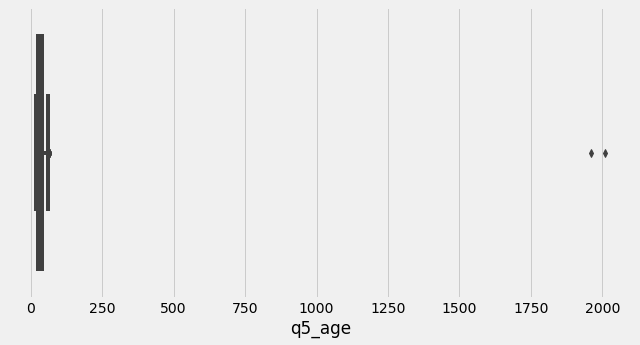

In [5]:
## there are outliers in age
## drop using interquartile range
import matplotlib.style as style
style.use('fivethirtyeight')
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['q5_age'])

In [6]:
# set up the interquantile range to drop outliers
# create new dataframe that excludes outliers
iqr=np.percentile(df['q5_age'],75)-np.percentile(df['q5_age'],25)
upper_limit=np.percentile(df['q5_age'],75)+1.5*iqr
lower_limit=np.percentile(df['q5_age'],25)-1.5*iqr

In [7]:
df = df[(df['q5_age']>lower_limit)&(df['q5_age']<upper_limit)]

<AxesSubplot:xlabel='q5_age'>

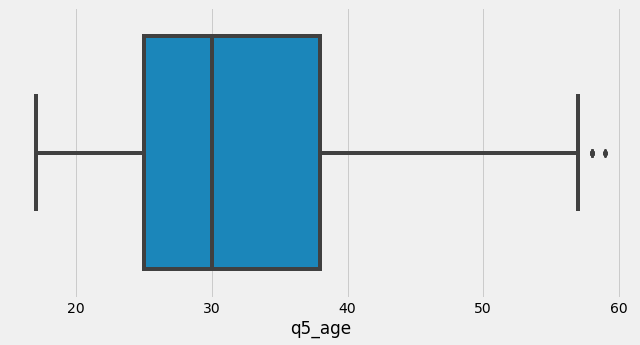

In [8]:
## there are outliers in age
## drop using interquartile range
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['q5_age'])

In [9]:
print(df['q74b_lkfpaidjb'].value_counts())

999                              3054
No, not looking for paid work    1086
Yes, looking for paid work        745
Name: q74b_lkfpaidjb, dtype: int64


In [10]:
# Drop inactives from dataframe
df.drop(df.index[df['q74b_lkfpaidjb'] == 'No, not looking for paid work'], inplace = True)

In [11]:
# define dependent variable employed as employment status
def employed(q74b_lkfpaidjb):
    if q74b_lkfpaidjb in ('999'):
        return True
    else:
        return False
    
df['employed'] = df['q74b_lkfpaidjb'].apply(lambda x: employed(x))

In [12]:
print(df['employed'].value_counts())

True     3054
False     745
Name: employed, dtype: int64


In [13]:
### Create youth feature as Boolean operator

In [14]:
def youth(q5_age):
    if q5_age < 35:
        return True
    else:
        return False
df['youth'] = df['q5_age'].apply(lambda x: youth(x))

In [15]:
print(df['youth'].value_counts())

True     2357
False    1442
Name: youth, dtype: int64


### Create ordinal skills proxy feature

In [16]:
# convert english proficiency to new numeric variable to proxy "skills"
def skills(q23_enprofc):
    if q23_enprofc in ('Or not at all?'):
        return 1
    elif q23_enprofc in ('Not very well'):
        return 2
    elif q23_enprofc in ('Well'):
        return 3
    elif q23_enprofc in ('Very well'):
        return 4
    else:
        return np.NAN
    
df['skills'] = df['q23_enprofc'].apply(lambda x: skills(x))

### Create ordinal education level feature

In [17]:
# convert education level to new numeric variable
# below high school, high school/diploma, college and above
def education(q32_edulevcompleted):
    if q32_edulevcompleted in ('999'):
        return np.NAN
    elif q32_edulevcompleted in ('Primary education', 'Middle/Intermediate education'):
        return 1
    elif q32_edulevcompleted in ('Regular Secondary education', 'Vocational or Technical Secondary education', 'Diploma'):
        return 2
    else:
        return 3
    
df['education'] = df['q32_edulevcompleted'].apply(lambda x: education(x))

### Create numeric feature as local labor market condition proxy

In [18]:
# create unemployment rate region numeric variable
# using 2018 LFS data since it's the earliest available... 
# regional unemployment shouldnt vary much in two years, but need to find earlier data


def regional_lm_conditions(q3_province):
    if q3_province in ('Makkah/Jeddah'):
        return 11.2
    elif q3_province in ('Riyadh'):
        return 11.1
    elif q3_province in ('Eastern Province'):
        return 7.1
    elif q3_province in ('Asir'):
        return 12.9
    elif q3_province in ('Madinah'):
        return 22.4
    elif q3_province in ('Hail'):
        return 16.2
    elif q3_province in ('AlBaha'):
        return 13.7
    elif q3_province in ('Tabuk'):
        return 16.5
    elif q3_province in ('Northern Province'):
        return 15.4
    elif q3_province in ('Qasim'):
        return 14.6
    elif q3_province in ('Jazan'):
        return 19.8
    elif q3_province in ('AlJouf'):
        return 27.7
    elif q3_province in ('Najran'):
        return 12.1
    
df['regional_lm_conditions'] = df['q3_province'].apply(lambda x: regional_lm_conditions(x))

### Boolean operators for binary values

##### Create youth feature as Boolean operator

In [19]:
def youth(q5_age):
    if q5_age < 35:
        return True
    else:
        return False
df['youth'] = df['q5_age'].apply(lambda x: youth(x))

##### Create dummies for all other categorical features

In [20]:
df = pd.get_dummies(df, columns=['URBAN_RURAL'])

In [21]:
df = pd.get_dummies(df, columns=['q2_gender'])

In [22]:
df = pd.get_dummies(df, columns=['q15_maritalstatus'])

In [23]:
df.isnull().sum()

responseid                                    0
q1_ksacitizenship                             0
q3_province                                   0
q4_area                                       0
q5_age                                        0
q23_enprofc                                   0
q24_enreadwrite                               0
q32_edulevcompleted                           0
q34_studyfield                                0
q62_paidwk7dys                                0
q74b_lkfpaidjb                                0
q75_seriouslylkfjb                            0
q76_hwlnglkfjb                                0
q83_past7daystatus                            0
q203b_totsalm                                 0
q203c_totsalmnoall                         2562
q226_fullskilljb                              0
q227_training                                 0
q232_jbsat                                    0
q474c_currentsit                              0
employed                                

In [24]:
# Drop subset of nulls from TRUE columns
df = df.dropna(subset = ['skills',
                         'education'
                        ])

In [25]:
df.shape

(3599, 34)

In [26]:
# drop variables that we no longer need
df = df.drop(columns=[
                      'q203c_totsalmnoall',
                      'q23_enprofc',
                      'q24_enreadwrite',
                      'q32_edulevcompleted',
                      'q75_seriouslylkfjb',
                      'q76_hwlnglkfjb',
                      'q83_past7daystatus',
                      'q226_fullskilljb',
                      'q227_training',
                      'q232_jbsat',
                      'q474c_currentsit',
                          'q34_studyfield',
                      'q62_paidwk7dys',
                      'q74b_lkfpaidjb',
                      'q203b_totsalm',
                      'responseid',
                      'q1_ksacitizenship',
                      'q3_province',
                      'q4_area',    
                     ])

In [27]:
df.shape

(3599, 15)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3599 entries, 0 to 4940
Data columns (total 15 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   q5_age                                   3599 non-null   int64  
 1   employed                                 3599 non-null   bool   
 2   youth                                    3599 non-null   bool   
 3   skills                                   3599 non-null   float64
 4   education                                3599 non-null   float64
 5   regional_lm_conditions                   3599 non-null   float64
 6   URBAN_RURAL_RURAL                        3599 non-null   uint8  
 7   URBAN_RURAL_URBAN                        3599 non-null   uint8  
 8   q2_gender_Female                         3599 non-null   uint8  
 9   q2_gender_Male                           3599 non-null   uint8  
 10  q15_maritalstatus_Divorced               3599 no

## 2. Data pre-process for machine learning models

### Check for multicollinearity
- Now all the data is in numeric format
- Highly correlated features can be dropped

In [29]:
# Check correlations
correlation=df.corr()
correlation

q5_age  employed     youth  \
q5_age                                   1.000000  0.225285 -0.831194   
employed                                 0.225285  1.000000 -0.175599   
youth                                   -0.831194 -0.175599  1.000000   
skills                                  -0.036543  0.055611  0.027239   
education                               -0.049768  0.044655  0.028399   
regional_lm_conditions                  -0.003964 -0.070312  0.004472   
URBAN_RURAL_RURAL                       -0.008302  0.015720  0.006779   
URBAN_RURAL_URBAN                        0.008302 -0.015720 -0.006779   
q2_gender_Female                         0.019893 -0.139297 -0.016444   
q2_gender_Male                          -0.019893  0.139297  0.016444   
q15_maritalstatus_Divorced               0.060851  0.015188 -0.046205   
q15_maritalstatus_Engaged to be married -0.081573  0.006750  0.088753   
q15_maritalstatus_Married                0.607023  0.232896 -0.520560   
q15_maritalstatus_Single                -0.621084 -0.242039  0.524489   
q15_maritalstatus_Widowed                0.095248  0.007995 -0.062535   

                                           skills  education  \
q5_age                                  -0.036543  -0.049768   
employed                                 0.055611   0.044655   
youth                                    0.027239   0.028399   
skills                                   1.000000   0.467246   
education                                0.467246   1.000000   
regional_lm_conditions                  -0.005375   0.042081   
URBAN_RURAL_RURAL                       -0.032427  -0.080066   
URBAN_RURAL_URBAN                        0.032427   0.080066   
q2_gender_Female                         0.153572   0.166143   
q2_gender_Male                          -0.153572  -0.166143   
q15_maritalstatus_Divorced              -0.003699  -0.004534   
q15_maritalstatus_Engaged to be married  0.018988   0.007926   
q15_maritalstatus_Married                0.005230   0.019520   
q15_maritalstatus_Single                -0.005706  -0.015527   
q15_maritalstatus_Widowed               -0.026099  -0.040616   

                                         regional_lm_conditions  \
q5_age                                                -0.003964   
employed                                              -0.070312   
youth                                                  0.004472   
skills                                                -0.005375   
education                                              0.042081   
regional_lm_conditions                                 1.000000   
URBAN_RURAL_RURAL                                      0.002702   
URBAN_RURAL_URBAN                                     -0.002702   
q2_gender_Female                                       0.001573   
q2_gender_Male                                        -0.001573   
q15_maritalstatus_Divorced                            -0.039962   
q15_maritalstatus_Engaged to be married               -0.021886   
q15_maritalstatus_Married                              0.014139   
q15_maritalstatus_Single                              -0.001889   
q15_maritalstatus_Widowed                              0.003702   

                                         URBAN_RURAL_RURAL  URBAN_RURAL_URBAN  \
q5_age                                           -0.008302           0.008302   
employed                                          0.015720          -0.015720   
youth                                             0.006779          -0.006779   
skills                                           -0.032427           0.032427   
education                                        -0.080066           0.080066   
regional_lm_conditions                            0.002702          -0.002702   
URBAN_RURAL_RURAL                                 1.000000          -1.000000   
URBAN_RURAL_URBAN                                -1.000000           1.000000   
q2_gender_Female                               

##### Plot correlation matrix

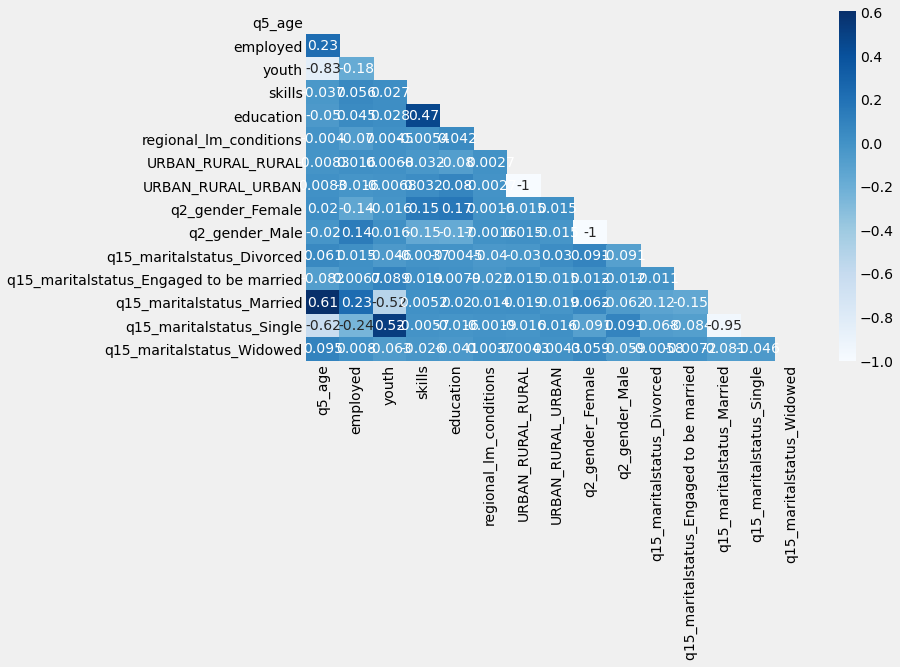

In [30]:
plt.subplots(figsize=(10, 6))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), annot=True, mask=matrix, cmap='Blues');

In [31]:
# drop additional [correlated] values of dummies
df = df.drop(columns=[
                      'q2_gender_Male',
                      'URBAN_RURAL_URBAN',
                      'q15_maritalstatus_Divorced',
                      'q15_maritalstatus_Engaged to be married',
                      'q15_maritalstatus_Single',
                      'q15_maritalstatus_Widowed'
                     ])

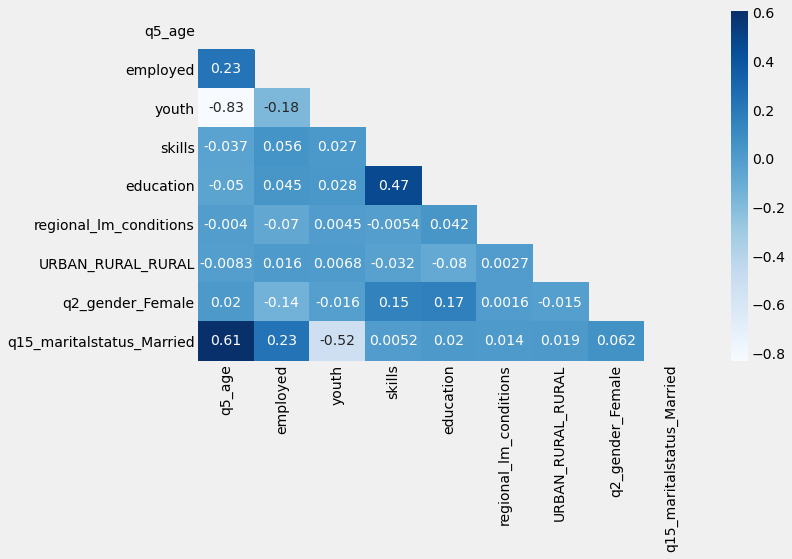

In [32]:
plt.subplots(figsize=(10, 6))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), annot=True, mask=matrix, cmap='Blues');

In [33]:
# actually lets drop youth and keep age
# drop additional [correlated] values of dummies
df = df.drop(columns=['youth'])

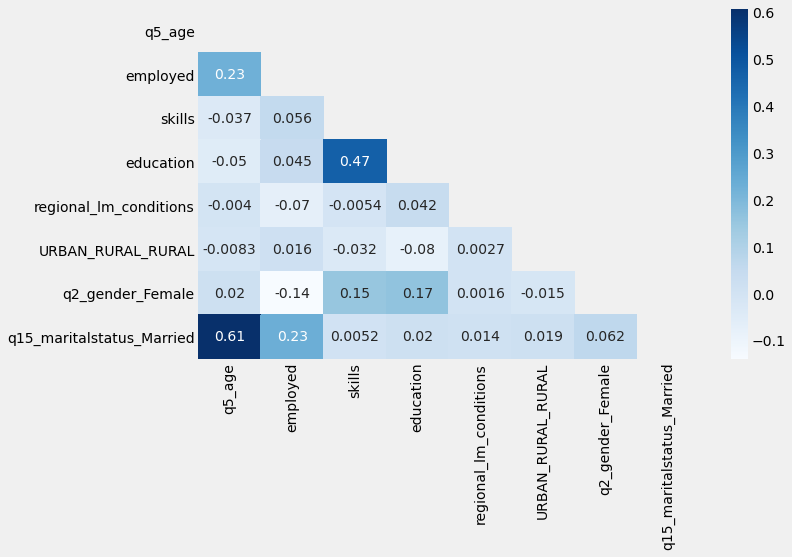

In [34]:
plt.subplots(figsize=(10, 6))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), annot=True, mask=matrix, cmap='Blues');

## education and skills are highly correlated
## let's leave them both for now since they are different
## but dropping one (maybe skills) could improve accuracy

### Scaling/normalizing features
skewed features, normalize
scaling may help the model fit/run
ML models work better when data is normally distributed

In [35]:
# create new data frame for ML model data pre-processing
# to avoid altering the main/original data frame
X = df

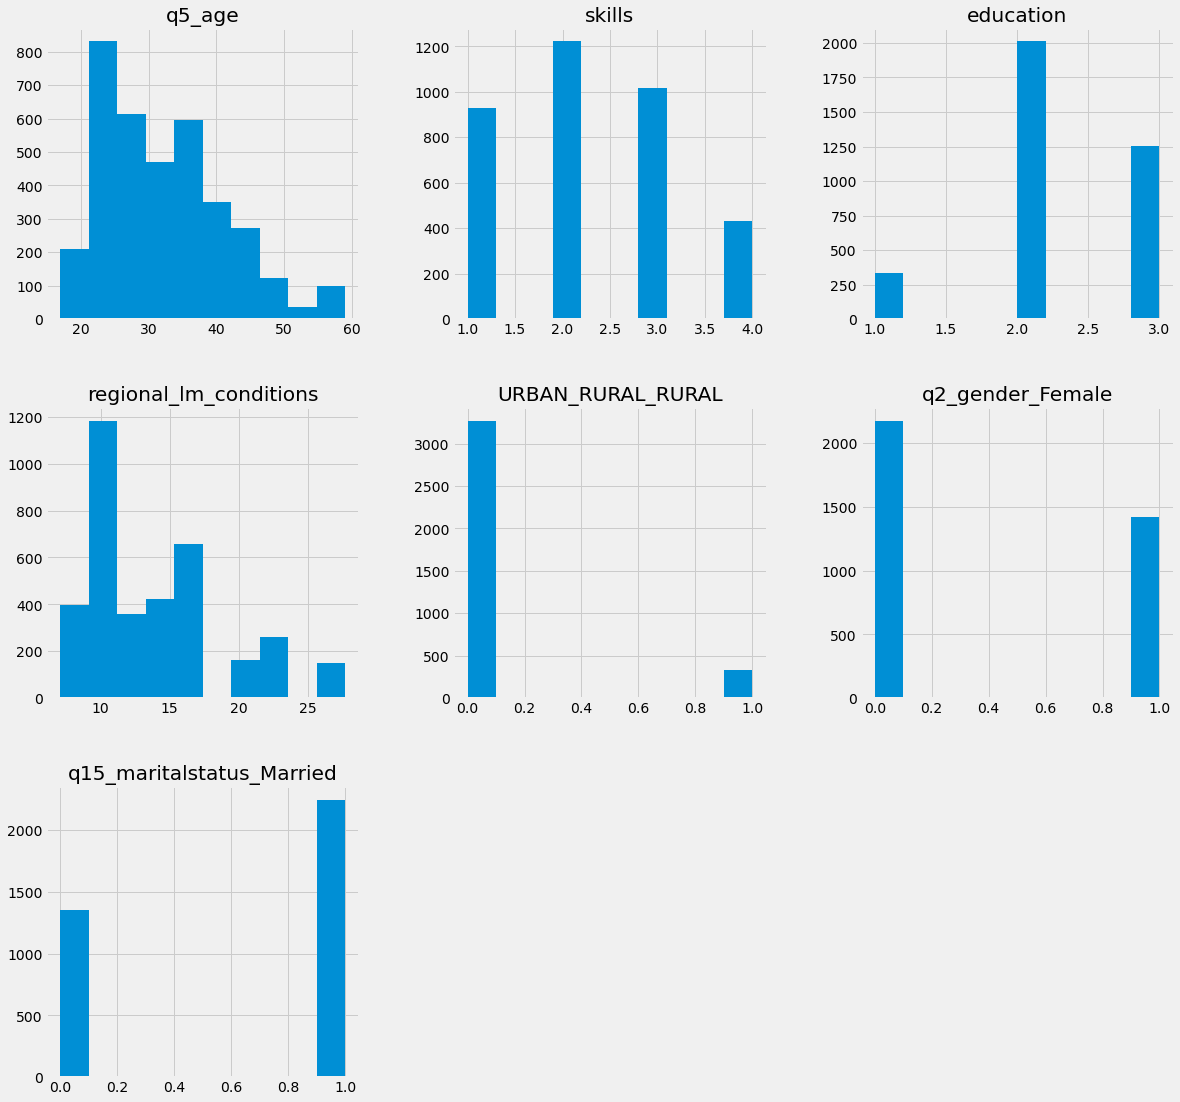

In [36]:
import matplotlib.style as style
X.hist(figsize=(18,18));

In [37]:
# scaling the numerical features to be normalized (Gaussian distribution)
# optional for logistic regression but might help the model
# in this case we will not use it for the prototype/baseline model
#might scale data for following iterations
from sklearn.preprocessing import Normalizer
scaler=Normalizer().fit(X)
scaled=scaler.transform(X)
scaled_X=pd.DataFrame(scaled)
scaled_X.head()

0         1         2         3         4    5         6         7
0  0.921526  0.032912  0.065823  0.098735  0.365319  0.0  0.032912  0.032912
1  0.930614  0.031020  0.062041  0.093061  0.344327  0.0  0.031020  0.031020
2  0.946928  0.000000  0.055702  0.055702  0.309144  0.0  0.027851  0.027851
3  0.958664  0.000000  0.025228  0.025228  0.280031  0.0  0.025228  0.025228
4  0.952925  0.026470  0.026470  0.052940  0.293818  0.0  0.026470  0.026470

In [38]:
# Scaling method for one particular column (i.e., LM conditions)
# if doing log transformation, some of the values might become -inf
# particularly if they are Zero values when scaled
# so need to filter those values out and then replace 
# this is only if there are a few, otherwise find other method
# for loop function scale regional unemployment rates:

def log_transform_clean(x):
    x=np.log(x)
    if np.isfinite(x):
        return x
    else:
        return np.NAN

X['regional_lm_conditions']=list(map(log_transform_clean, X['regional_lm_conditions']))

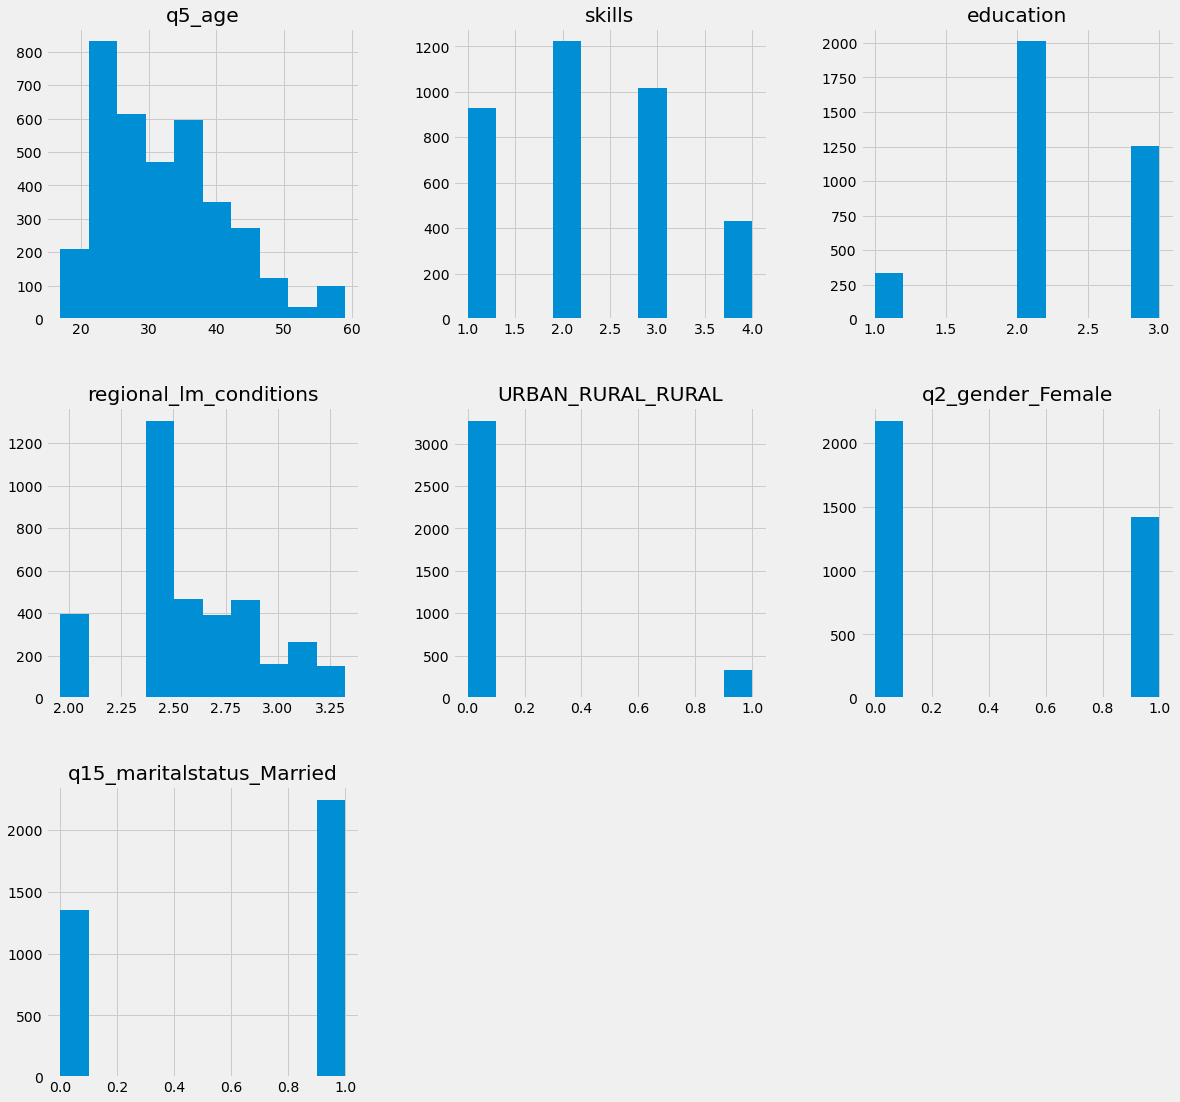

In [39]:
style.use('fivethirtyeight')
X.hist(figsize=(18,18));

## 3. Machine learning models

### Logistic regression machine learning model

In [40]:
lr_df = X

##### Rationale for model selection
- In Logistic Regression, we wish to model a dependent variable(Y) in terms of one or more independent variables(X). It is a method for classification. This algorithm is used for the dependent variable that is Categorical. Y is modeled using a function that gives output between 0 and 1 for all values of X. In Logistic Regression, the Sigmoid (aka Logistic) Function is used.

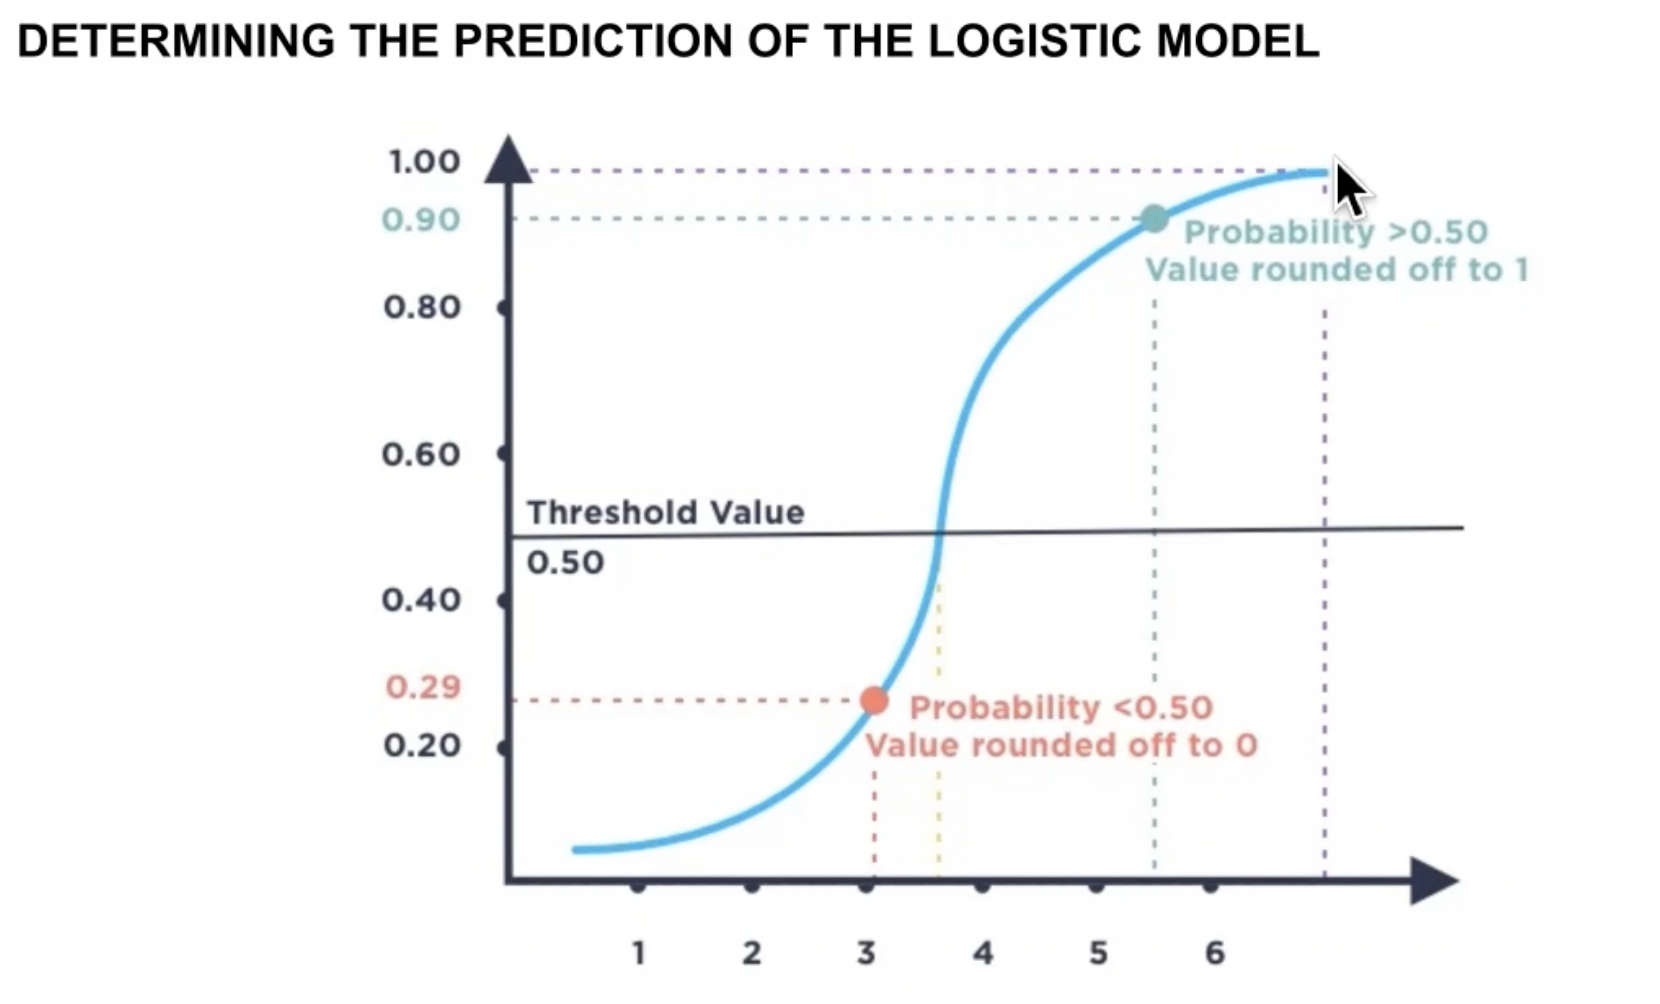

In [41]:
#Import library
from IPython.display import Image
# Load image from local storage
Image(filename = "Logistic regression.png", width = 600, height = 300)

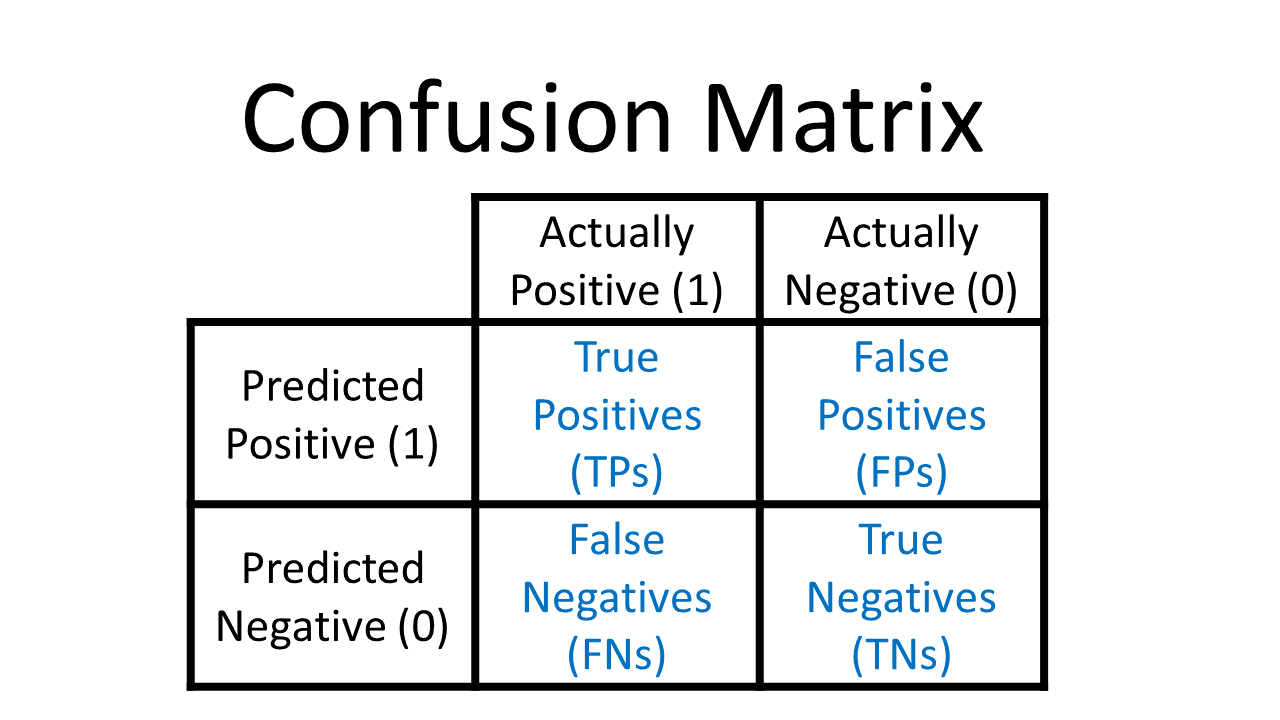

In [42]:
#Import library
from IPython.display import Image
# Load image from local storage
Image(filename = "CMatrix.png", width = 600, height = 300)

In [43]:
# Spit off the dependent variable

In [44]:
# y = dependent variable - employed
y = lr_df['employed']
# independent variables are X (excluding 'employment status')
X=lr_df.drop(columns=['employed'])

In [45]:
X

q5_age  skills  education  regional_lm_conditions  URBAN_RURAL_RURAL  \
0         28     2.0        3.0                2.406945                  0   
1         30     2.0        3.0                2.406945                  0   
2         34     2.0        2.0                2.406945                  0   
3         38     1.0        1.0                2.406945                  0   
5         36     1.0        2.0                2.406945                  0   
...      ...     ...        ...                     ...                ...   
4933      29     1.0        2.0                2.803360                  0   
4934      40     2.0        2.0                2.803360                  0   
4935      25     4.0        3.0                2.803360                  0   
4936      22     1.0        2.0                2.803360                  0   
4940      35     1.0        2.0                1.960095                  0   

      q2_gender_Female  q15_maritalstatus_Married  
0                    1                          1  
1                    1                          1  
2                    1                          1  
3                    1                          1  
5                    1                          1  
...                ...                        ...  
4933                 0                          1  
4934                 0                          1  
4935                 0                          0  
4936                 0                          0  
4940                 1                          1  

[3599 rows x 7 columns]

#### Logistic regression model, parameters
- 70/30 train/test since it's not a super large dataset
- Random state = 40, 
- means the shuffling apply to the data before the split
- A repeatable shuffling of the deck so it stays consistent
- We want randomness but we want to be able to reproduce it
- We can change the train/test proportion for next iteration

#### Reference: Sklearn documentation for logistic regression model
- check documentation to add to the paramenters as wished, i.e., Max iterations, etc
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html   

In [46]:
# import the logistic regression model
from sklearn.linear_model import LogisticRegression

#### Import train test split model and set parameters

In [47]:
# Import train test split tool
# feed in X and y and set up parameters
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=40)

#### Apply parameters and train the model 

In [48]:
# define the logistic regression model
classification=LogisticRegression(solver='liblinear', multi_class='ovr').fit(X_train, y_train)

In [49]:
# creating predictions based on the trained model
y_pred=classification.predict(X_test)

#### Evaluate accuracy and test

###### Definition of metrics
- fpr = false positive rate
- tpr, true positive rate
- auc = area under the curve
- roc = receiver operating characteristics

In [50]:
# calculating the main metrics
probabilities=classification.predict_proba(X_test)
probabilities

array([[0.09052259, 0.90947741],
       [0.18720288, 0.81279712],
       [0.05495692, 0.94504308],
       ...,
       [0.07612433, 0.92387567],
       [0.26017367, 0.73982633],
       [0.04111916, 0.95888084]])

In [51]:
import sklearn.metrics as metrics

In [52]:
# calculating the main metrics
probabilities=classification.predict_proba(X_test)
preds=probabilities[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc=metrics.auc(fpr,tpr)
print(roc_auc)

0.7137750330638423


### 71% accuracy for the baseline model... 
- Not bad, some OECD countries have lower accuracy
- Belgium, Ireland, Netherlands < 70% accuracy
- Surely the accuracy will improve for following iterations

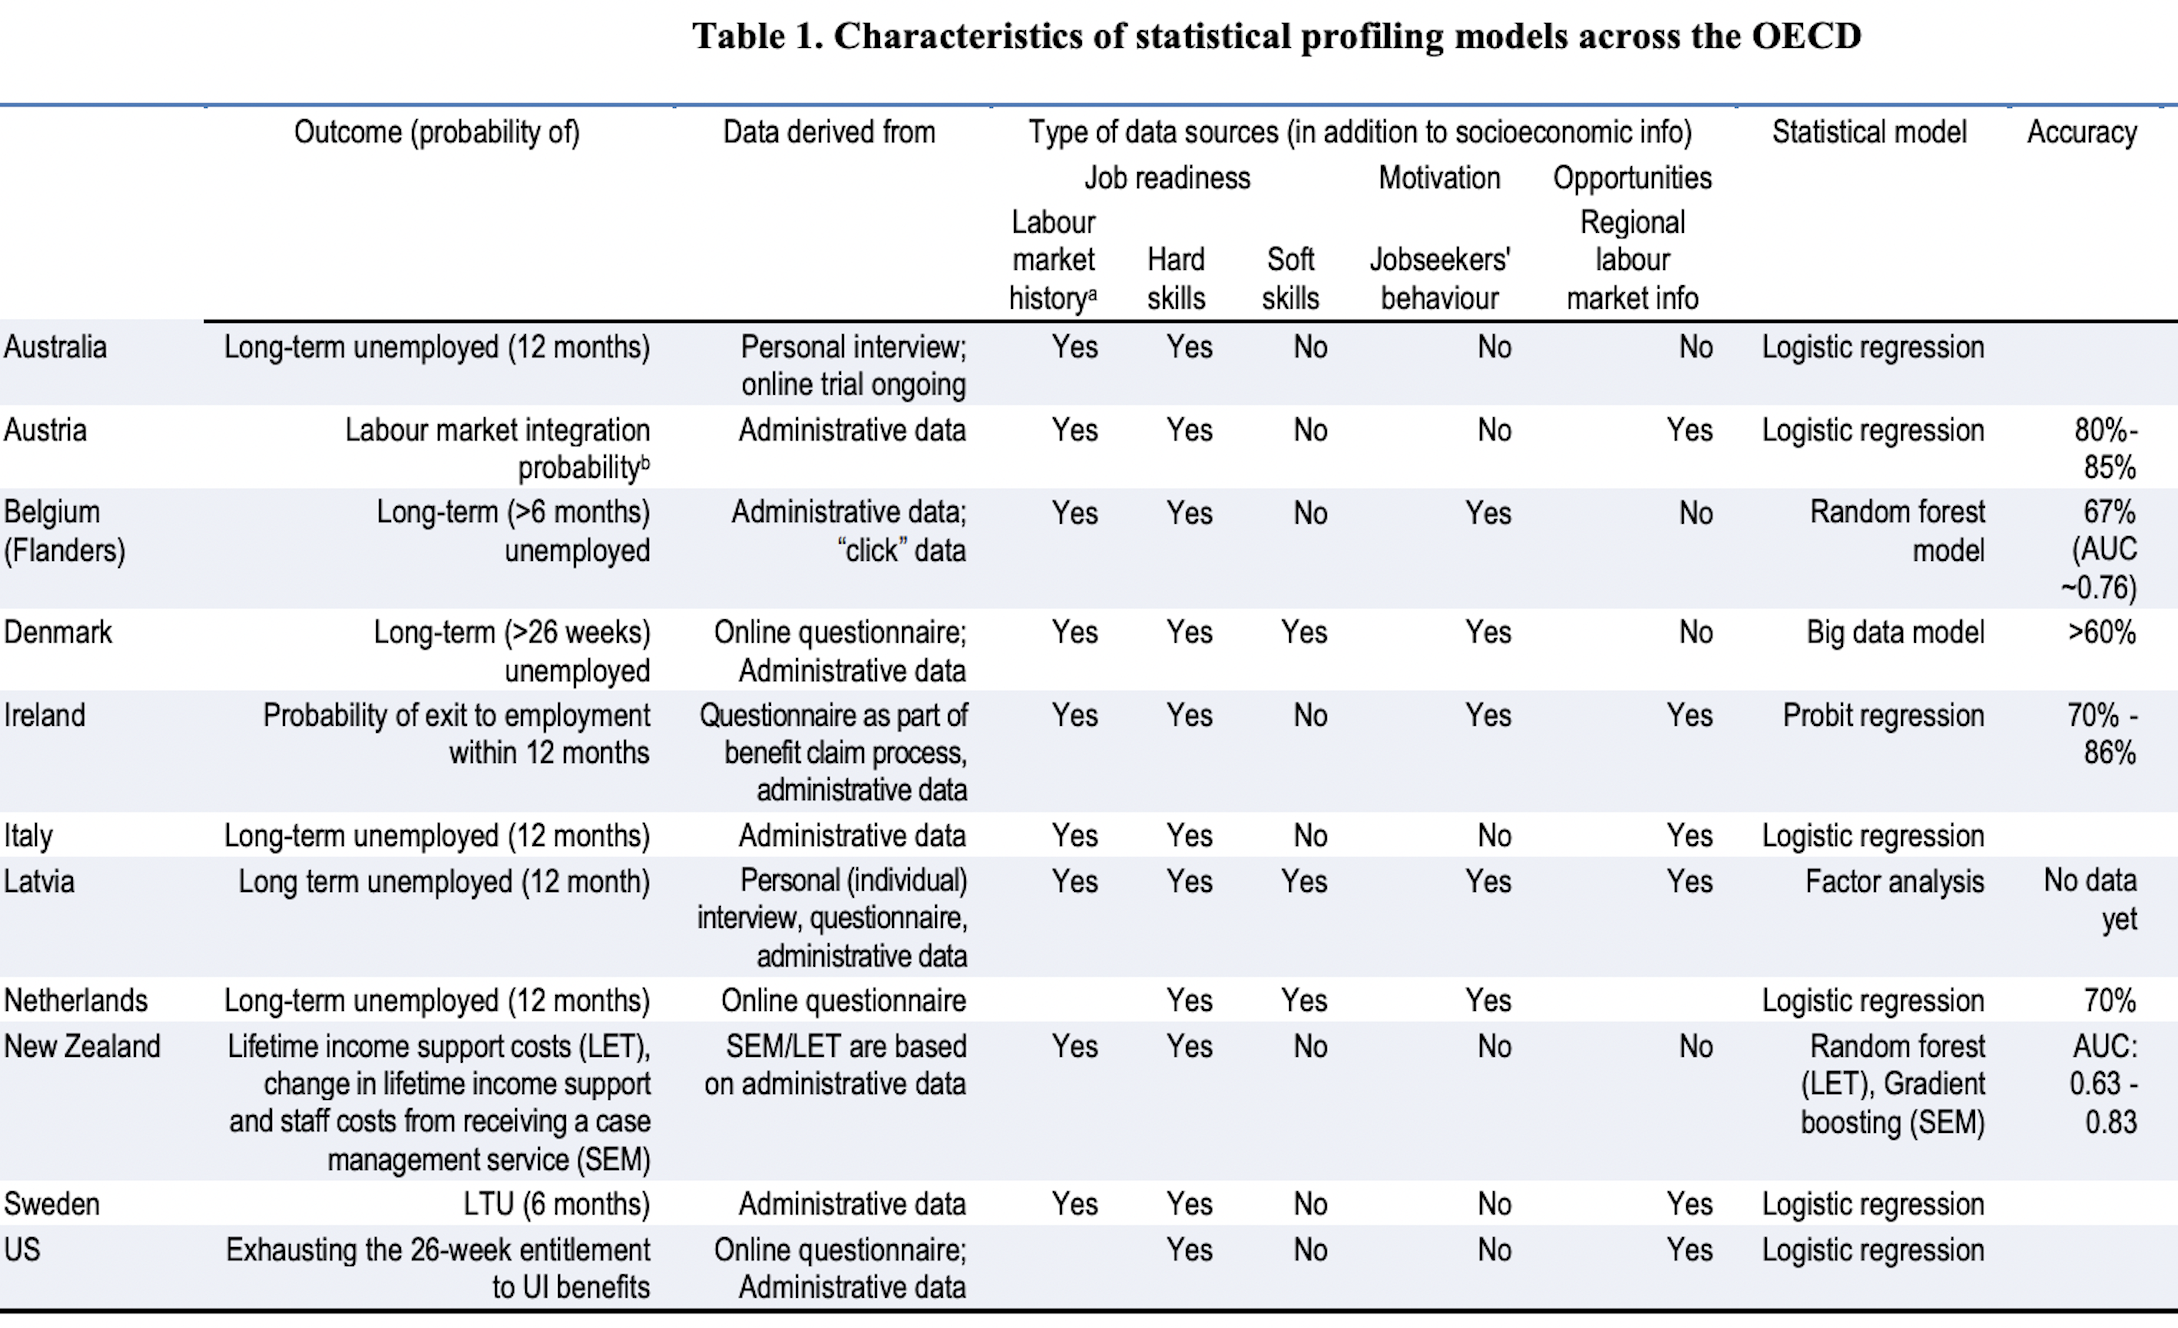

In [53]:
#Import library
from IPython.display import Image
# Load image from local storage
Image(filename = "OECD_Countries.png", width = 600, height = 300)

##### Visualize the roc curve plot

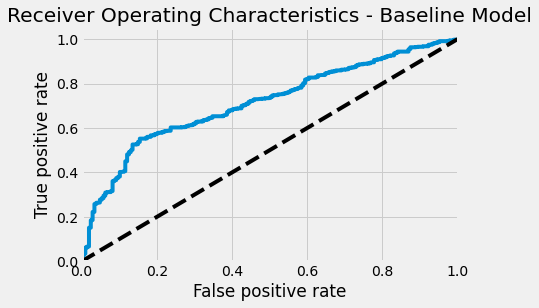

In [54]:
# Plot area under the curve as a share of roc
plt.title('Receiver Operating Characteristics - Baseline Model')
plt.plot(fpr,tpr, label="AUC"%roc_auc)
plt.plot([0, 1], [0,1], 'k--',)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

#### Interpretation
- We want the curve to be as close to the top left as possible 
- everything below that is the area under the curve
- so essentially we want more of the space to fall under the curve

##### Description:
- A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. 

##### Plot the confusion matrix

In [55]:
from sklearn.metrics import accuracy_score
predictions = classification.predict(X_test)

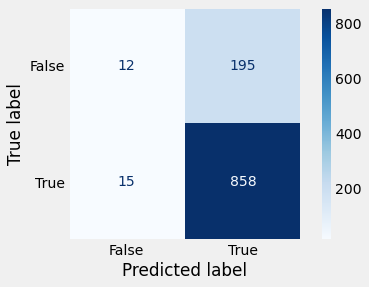

In [56]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
accuracy_score(y_test,predictions)
confusion_matrix(y_test,predictions)
plot_confusion_matrix(classification,X_test, y_test, cmap=plt.cm.Blues)
plt.grid(None)
plt.show();

##### Plot confusion matrix including instances as % share of train data

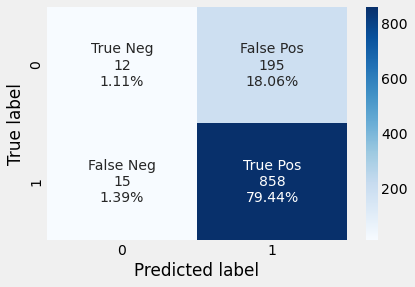

In [57]:
cnfmat = confusion_matrix(y_test,y_pred)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cnfmat.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cnfmat.flatten()/np.sum(cnfmat)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnfmat, annot=labels, fmt='', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#### Interpretation

- 12: false negative, correctly identified unemployed
- 861: true positives: correctly identified employed 



- Bottom line: the model is better at predicting the employed=True than unemployed because the data is quite imbalanced within the taget variable of 3062 employed and 746 unemployed. 



- This is based on the proportion of the data (30%) reserved for testing
- Proportion wise, the model is good at predicting employed
- So I can change the proportion

##### Potential checks to improve accuracy of baseline model in following iterations
- insufficient quantity of training data
- non-representative training data
- poor quality data
- irrelevant features
- overfitting the training data
- underfitting the training data

# K-means algorithm 
- unsupervised, unlabeled machine learning method for clustering
- the purpose is to explore relations in the data
- cluster individuals accordingly based on similarities
- we can drop the clusters if no interesting findings identified

In [58]:
km_X = df

In [59]:
from sklearn.cluster import KMeans

# define the model, fit the model to the data 

kmeans = KMeans(n_clusters=8, random_state=40)
kmeans.fit(km_X)

KMeans(random_state=40)

In [60]:
#look at the cluster centres 
kmeans.cluster_centers_

array([[20.61038961,  0.55519481,  2.03896104,  2.02597403,  2.58483966,
         0.08116883,  0.33766234,  0.05519481],
       [39.75428571,  0.89428571,  2.25428571,  2.27714286,  2.59091024,
         0.09428571,  0.49142857,  0.97714286],
       [30.34174757,  0.86019417,  2.34757282,  2.29320388,  2.56333792,
         0.07572816,  0.40194175,  0.80776699],
       [45.98477157,  0.90101523,  2.23096447,  2.22335025,  2.58460931,
         0.07106599,  0.41624365,  0.94923858],
       [26.97205589,  0.8003992 ,  2.31337325,  2.28143713,  2.60524948,
         0.11377246,  0.33932136,  0.43512974],
       [54.82089552,  0.91791045,  1.94029851,  1.89552239,  2.62574066,
         0.08955224,  0.29850746,  0.94776119],
       [35.03308271,  0.8887218 ,  2.26917293,  2.30225564,  2.57126252,
         0.10827068,  0.41654135,  0.92781955],
       [24.28688525,  0.69125683,  2.34562842,  2.33879781,  2.58409502,
         0.08469945,  0.39480874,  0.18442623]])

In [61]:
# Predicting / assigning the clusters:
clusters = kmeans.predict(km_X)

In [62]:
# Check the size of the clusters
pd.Series(clusters).value_counts().sort_index()

0    308
1    350
2    515
3    394
4    501
5    134
6    665
7    732
dtype: int64

In [63]:
# Explore the cluster assignment by placing it in the original dataset
X_cluster=pd.DataFrame(km_X)
X_cluster['cluster']=clusters
X_cluster.head(30)

q5_age  employed  skills  education  regional_lm_conditions  \
0       28      True     2.0        3.0                2.406945   
1       30      True     2.0        3.0                2.406945   
2       34     False     2.0        2.0                2.406945   
3       38     False     1.0        1.0                2.406945   
5       36      True     1.0        2.0                2.406945   
6       28      True     2.0        1.0                2.406945   
7       24      True     2.0        2.0                2.406945   
8       36      True     2.0        2.0                2.406945   
10      36      True     3.0        3.0                2.785011   
11      30      True     2.0        3.0                2.406945   
12      55      True     1.0        1.0                2.406945   
13      31      True     1.0        1.0                2.406945   
14      36      True     2.0        2.0                2.406945   
15      22      True     2.0        2.0                2.406945   
16      40      True     2.0        2.0                2.406945   
18      21      True     2.0        2.0                2.406945   
19      36     False     1.0        1.0                2.406945   
22      45      True     2.0        3.0                2.406945   
23      24     False     1.0        2.0                2.406945   
24      24      True     3.0        3.0                2.406945   
25      26      True     2.0        2.0                2.406945   
26      34      True     2.0        2.0                2.406945   
27      31      True     3.0        3.0                2.406945   
28      26      True     3.0        3.0                2.406945   
29      25      True     4.0        3.0                2.406945   
30      23      True     2.0        2.0                2.406945   
31      34      True     4.0        3.0                2.406945   
32      26     False     3.0        3.0                2.406945   
33      36     False     1.0        2.0                2.406945   
34      30      True     2.0        2.0                2.406945   

    URBAN_RURAL_RURAL  q2_gender_Female  q15_maritalstatus_Married  cluster  
0                   0                 1                          1        4  
1                   0                 1                          1        2  
2                   0                 1                          1        6  
3                   0                 1                          1        1  
5                   0                 1                          1        6  
6                   0                 0                          1        4  
7                   0                 1                          1        7  
8                   0                 0                          1        6  
10                  0                 1                          1        6  
11                  0                 1                          0        2  
12                  0                 0                          1        5  
13                  0                 0                          0        2  
14                  0                 0                          1        6  
15                  0                 0                          0        0  
16                  0                 1                          0        1  
18                  0                 1                          0        0  
19                  0                 1                          1        6  
22                  0                 1                          1        3  
23                  0                 1                          1        7  
24                  0                 1                          0        7  
25                  0                 1                          0        4  
26                  0                 1                          1        6  
27                  0                 0                          1        2  
28                  0                 0               

In [64]:
# Try to run Kmeans with all values of K, from 1 to 20
K = range(1, 20)

# For each model, store the inertia in a list
inertia = []

for k in K:
    
    kmeans=KMeans(n_clusters=k, random_state=40)
    kmeans.fit(km_X)
    inertia.append(kmeans.inertia_)
    
print(inertia)

[304045.70058745646, 112145.28796285436, 63438.54433739757, 48316.70275354424, 34591.47722648559, 22342.94689387397, 15999.630602162924, 12137.177889939256, 11038.450991755391, 10505.966274830456, 9964.888339470828, 9510.117134509253, 9219.514577779213, 8853.484953684272, 8496.227779469385, 8100.664163191741, 7793.582911636307, 7656.263400831451, 7354.5778568928845]


Text(0.5, 1.0, 'Elbow Method showing the optimal k')

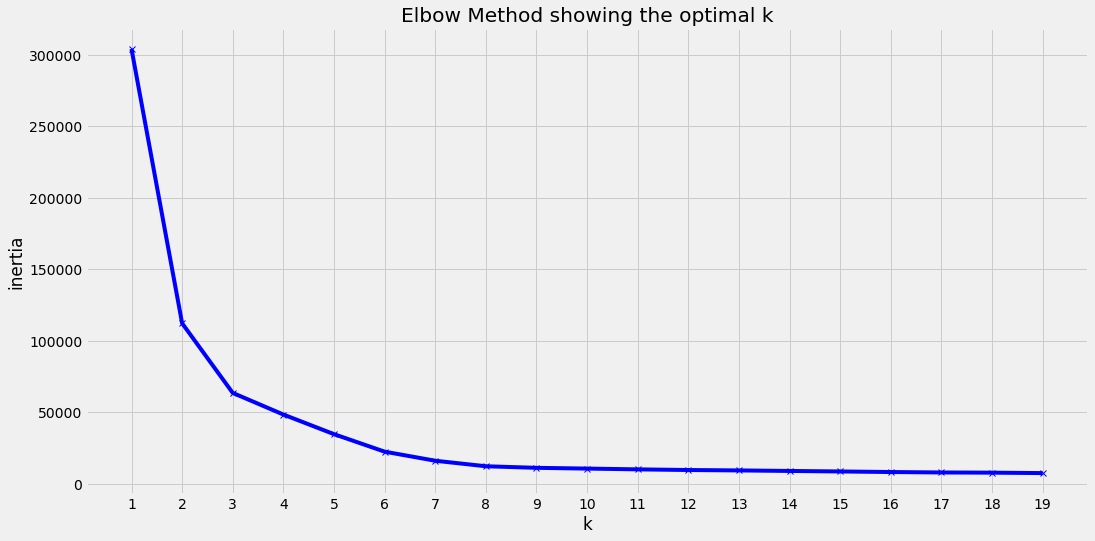

In [65]:
# Plot the results: Elbow method
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
style.use('fivethirtyeight')
plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

In [66]:
# Silhouette method

from sklearn.metrics import silhouette_score

K = range(2, 20)

silhouettes = []

for k in K: 
    kmeans=KMeans(n_clusters=k, random_state=40)
    kmeans.fit(km_X)
    silhouettes.append(silhouette_score(km_X, kmeans.predict(km_X)))

Text(0, 0.5, 'silhouette score')

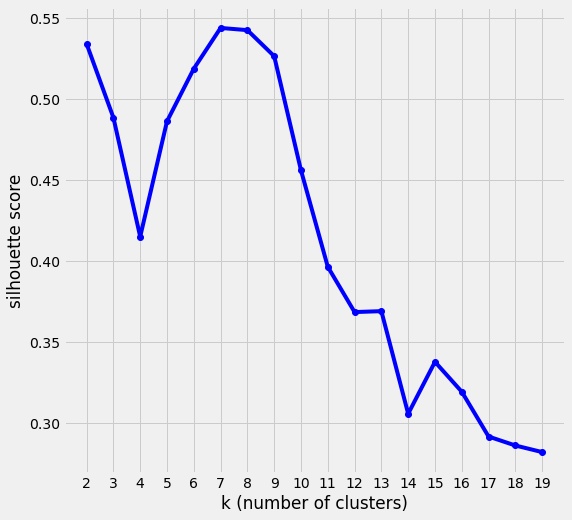

In [67]:
import matplotlib.pyplot as plt
style.use('fivethirtyeight')
plt.figure(figsize=(8,8))
plt.plot(K, silhouettes, 'bo-')
plt.xlabel('k (number of clusters)')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.ylabel('silhouette score')

In [68]:
kmeans = KMeans(n_clusters=4,
                init="random",
                n_init=10,  
                max_iter=200,
                tol=0,
                algorithm="full",
                random_state=40)
kmeans.fit(km_X)
print(kmeans.inertia_)

48316.70275354425


In [69]:
clusters = kmeans.predict(km_X)

In [70]:
# Check the size of the clusters
pd.Series(clusters).value_counts().sort_index()

0     969
1     841
2     574
3    1215
dtype: int64

In [71]:
kmeans

KMeans(algorithm='full', init='random', max_iter=200, n_clusters=4,
       random_state=40, tol=0)

In [72]:
cluster_list = kmeans.predict(km_X)

In [73]:
km_X['cluster'] = cluster_list.tolist()

In [74]:
km_X

q5_age  employed  skills  education  regional_lm_conditions  \
0         28      True     2.0        3.0                2.406945   
1         30      True     2.0        3.0                2.406945   
2         34     False     2.0        2.0                2.406945   
3         38     False     1.0        1.0                2.406945   
5         36      True     1.0        2.0                2.406945   
...      ...       ...     ...        ...                     ...   
4933      29      True     1.0        2.0                2.803360   
4934      40      True     2.0        2.0                2.803360   
4935      25      True     4.0        3.0                2.803360   
4936      22      True     1.0        2.0                2.803360   
4940      35     False     1.0        2.0                1.960095   

      URBAN_RURAL_RURAL  q2_gender_Female  q15_maritalstatus_Married  cluster  
0                     0                 1                          1        1  
1                     0                 1                          1        1  
2                     0                 1                          1        0  
3                     0                 1                          1        0  
5                     0                 1                          1        0  
...                 ...               ...                        ...      ...  
4933                  0                 0                          1        1  
4934                  0                 0                          1        0  
4935                  0                 0                          0        3  
4936                  0                 0                          0        3  
4940                  0                 1                          1        0  

[3599 rows x 9 columns]

In [75]:
#predict the labels of clusters.
label = kmeans.fit_predict(km_X)

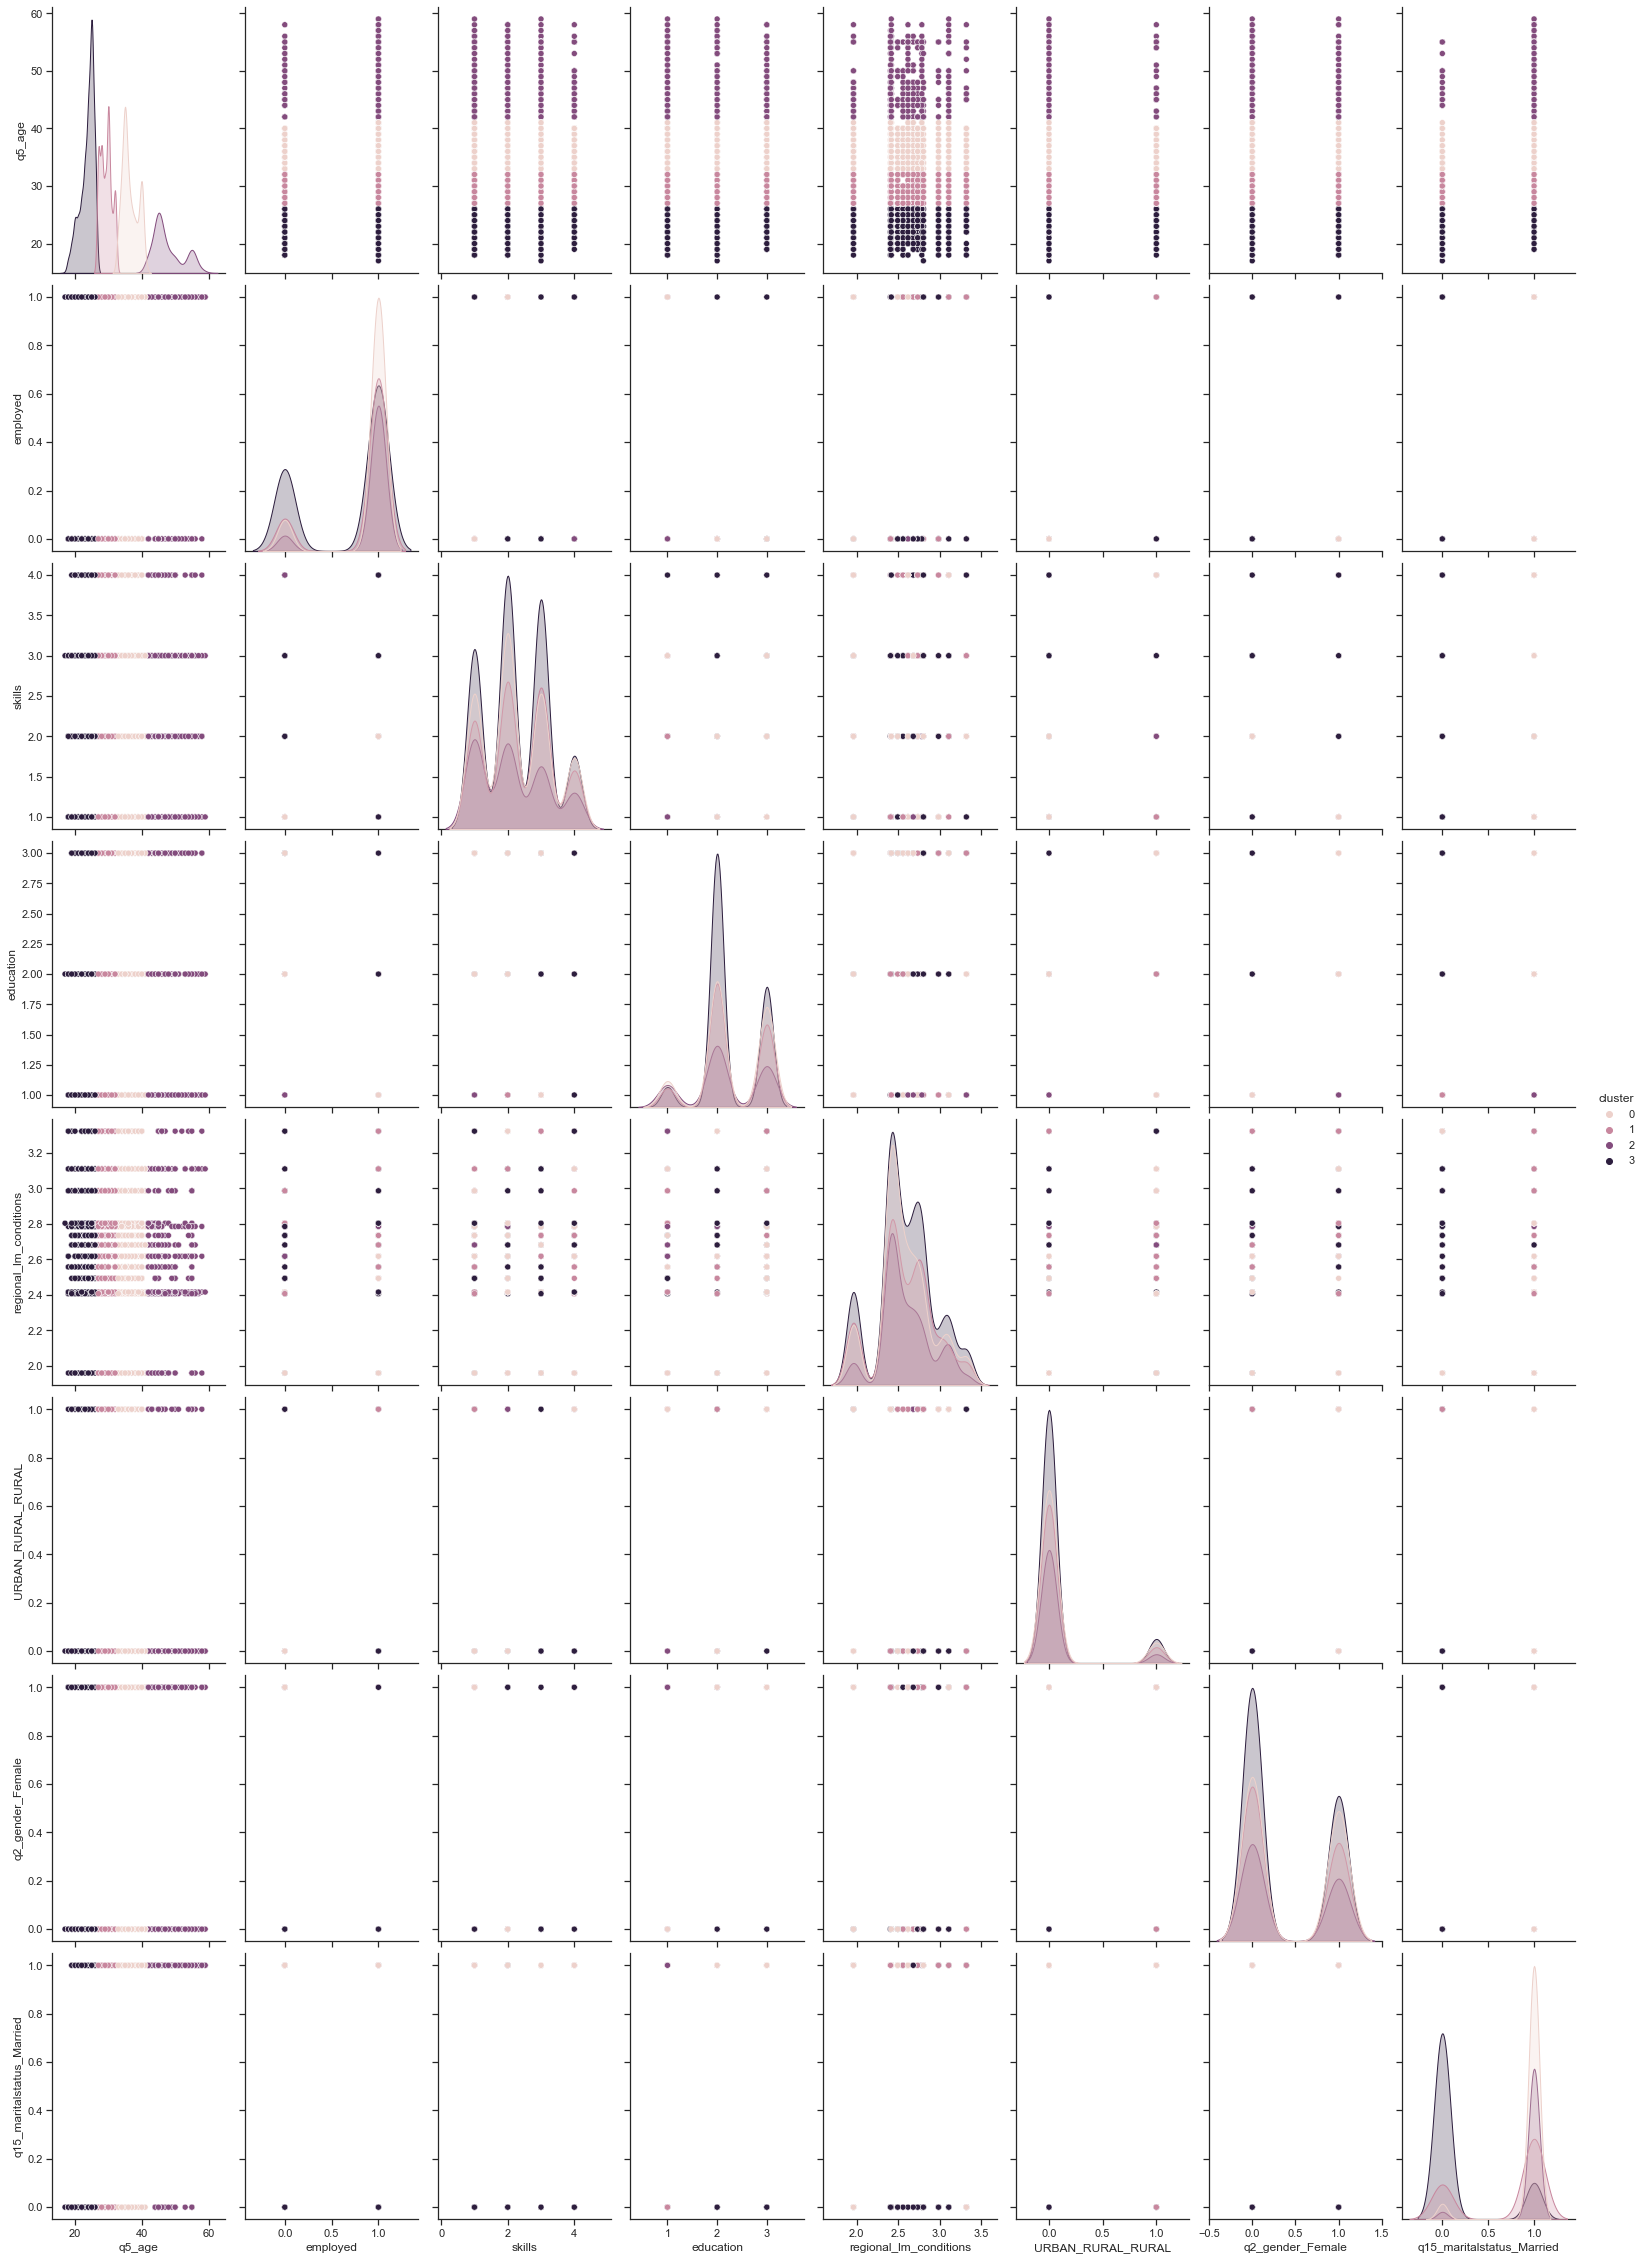

In [76]:
import seaborn as sns
sns.set_theme(style="ticks")

sns.pairplot(km_X, hue="cluster", height=4, aspect=.7)

In [77]:
km_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3599 entries, 0 to 4940
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   q5_age                     3599 non-null   int64  
 1   employed                   3599 non-null   bool   
 2   skills                     3599 non-null   float64
 3   education                  3599 non-null   float64
 4   regional_lm_conditions     3599 non-null   float64
 5   URBAN_RURAL_RURAL          3599 non-null   uint8  
 6   q2_gender_Female           3599 non-null   uint8  
 7   q15_maritalstatus_Married  3599 non-null   uint8  
 8   cluster                    3599 non-null   int64  
dtypes: bool(1), float64(3), int64(2), uint8(3)
memory usage: 182.8 KB


In [78]:
km_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3599 entries, 0 to 4940
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   q5_age                     3599 non-null   int64  
 1   employed                   3599 non-null   bool   
 2   skills                     3599 non-null   float64
 3   education                  3599 non-null   float64
 4   regional_lm_conditions     3599 non-null   float64
 5   URBAN_RURAL_RURAL          3599 non-null   uint8  
 6   q2_gender_Female           3599 non-null   uint8  
 7   q15_maritalstatus_Married  3599 non-null   uint8  
 8   cluster                    3599 non-null   int64  
dtypes: bool(1), float64(3), int64(2), uint8(3)
memory usage: 182.8 KB


# Random forest

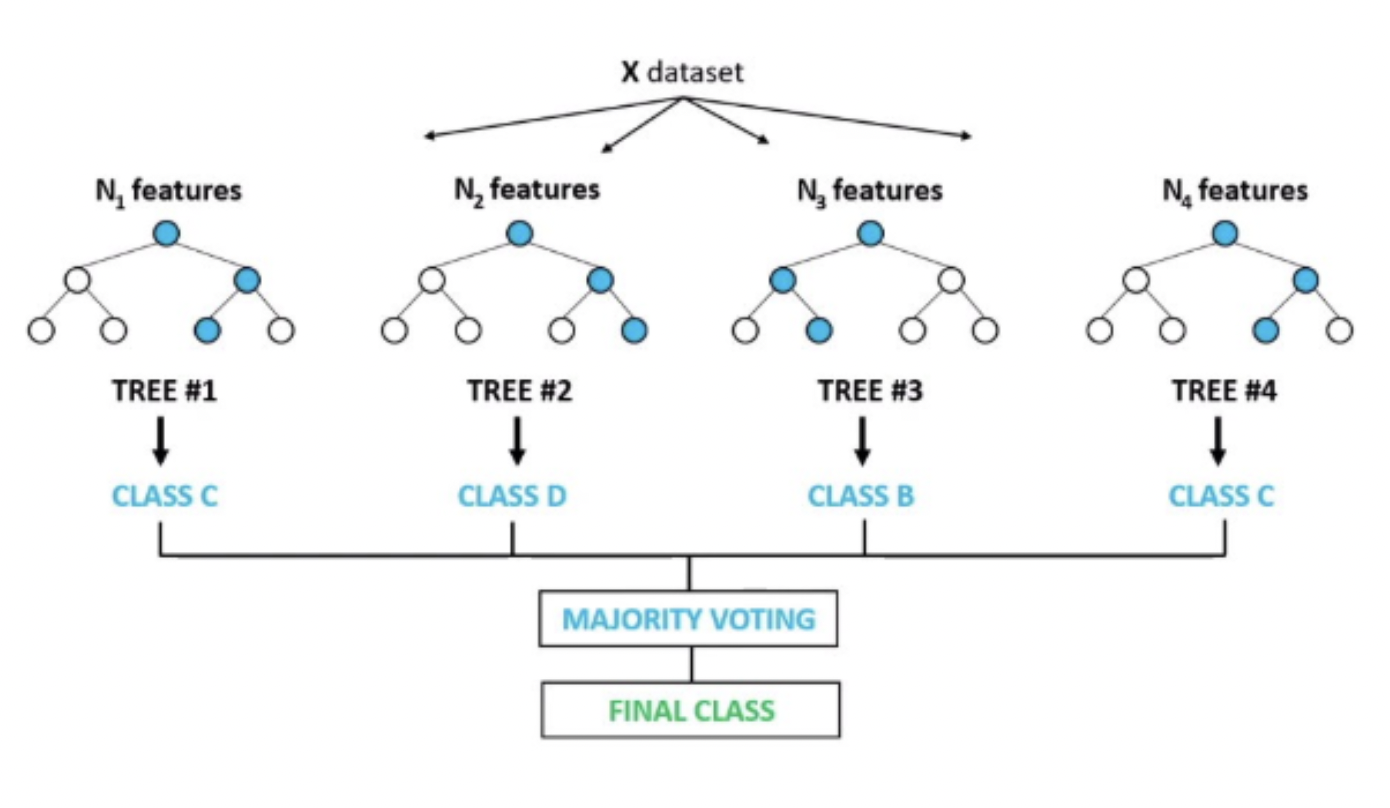

In [79]:
#Import library
from IPython.display import Image
# Load image from local storage
Image(filename = "random-forest.png", width = 600, height = 300)

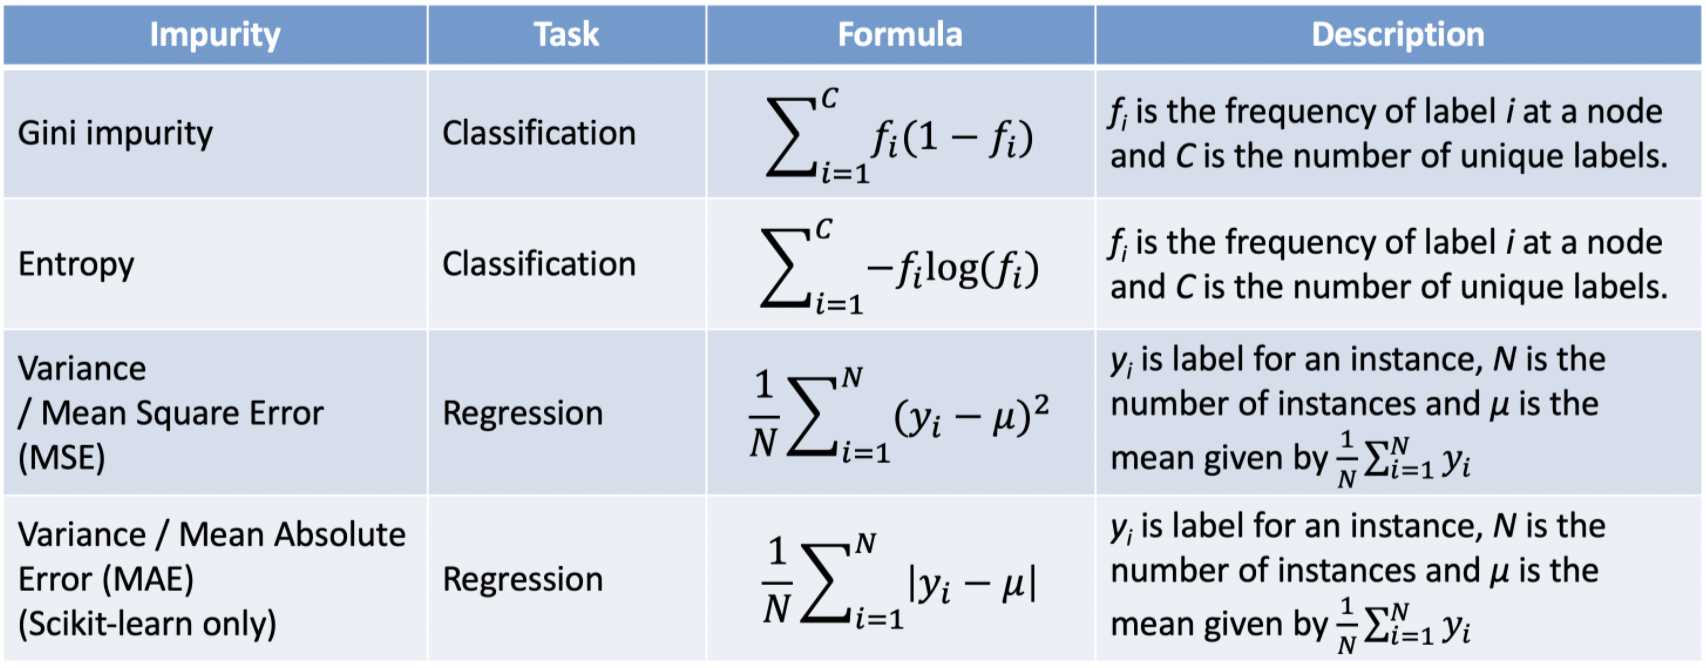

In [80]:
#Import library
from IPython.display import Image
# Load image from local storage
Image(filename = "random forest.png", width = 600, height = 300)

#### Useful reference: The Mathematics of Decision Trees, Random Forest and Feature Importance in Scikit-learn and Spark
- https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3

In [81]:
rf_df = df.drop(columns=['cluster'])

In [82]:
rf_df

q5_age  employed  skills  education  regional_lm_conditions  \
0         28      True     2.0        3.0                2.406945   
1         30      True     2.0        3.0                2.406945   
2         34     False     2.0        2.0                2.406945   
3         38     False     1.0        1.0                2.406945   
5         36      True     1.0        2.0                2.406945   
...      ...       ...     ...        ...                     ...   
4933      29      True     1.0        2.0                2.803360   
4934      40      True     2.0        2.0                2.803360   
4935      25      True     4.0        3.0                2.803360   
4936      22      True     1.0        2.0                2.803360   
4940      35     False     1.0        2.0                1.960095   

      URBAN_RURAL_RURAL  q2_gender_Female  q15_maritalstatus_Married  
0                     0                 1                          1  
1                     0                 1                          1  
2                     0                 1                          1  
3                     0                 1                          1  
5                     0                 1                          1  
...                 ...               ...                        ...  
4933                  0                 0                          1  
4934                  0                 0                          1  
4935                  0                 0                          0  
4936                  0                 0                          0  
4940                  0                 1                          1  

[3599 rows x 8 columns]

In [83]:
# import the tools - for random forest
from sklearn.ensemble import RandomForestRegressor #calculated in the model .feature_importances_
from sklearn.feature_selection import SelectFromModel # can try this one out after reviewing the documentation 

In [84]:
X=rf_df.drop(columns=['employed'])
y=rf_df['employed']

In [85]:
tree=RandomForestRegressor()

In [86]:
tree.fit(X,y)

RandomForestRegressor()

In [87]:
tree.feature_importances_

array([0.34928601, 0.14227536, 0.07732709, 0.26980585, 0.04213044,
       0.06779727, 0.05137798])

In [88]:
df_plot = pd.DataFrame(tree.feature_importances_)

In [89]:
sorted_col=tree.feature_importances_.argsort()

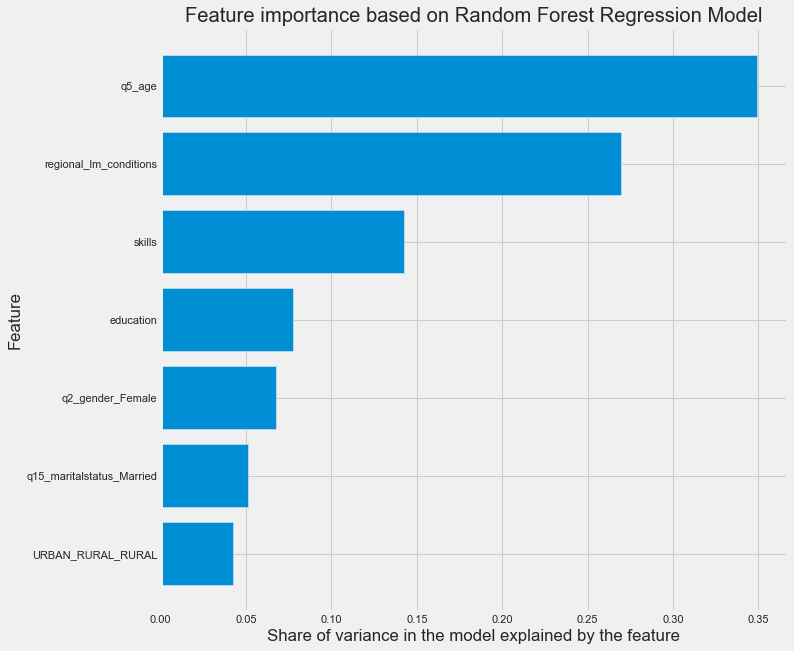

In [90]:
style.use('fivethirtyeight')
plt.figure(figsize=(10, 10))
plt.barh(X.columns[sorted_col],tree.feature_importances_[sorted_col])
plt.title("Feature importance based on Random Forest Regression Model")
plt.xlabel("Share of variance in the model explained by the feature")
plt.ylabel("Feature");

## Feature Importance
- Feature importance is calculated as the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature.